# CapsNet MNIST Experiment

## Envoirnment Setting 

Import the Require Libraries

In [20]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torchvision import datasets, transforms

USE_CUDA = True

## The Architecture of CapsNet

A block of Convolution layer and Relu Activation on it

In [21]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels=1, out_channels=256, kernel_size=9):
        super(ConvLayer, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=kernel_size,
                               stride=1
                             )

    def forward(self, x):
        return F.relu(self.conv(x))

**Reason:** This class creates the first layer of capsules directly from the input data. It transforms the convolutional output into capsule vectors, preparing them for the next layers.

In [ ]:

class PrimaryCaps(nn.Module):
    def __init__(self, num_capsules=8, in_channels=256, out_channels=32, kernel_size=9):
        super(PrimaryCaps, self).__init__()

        # Create a list of convolutional layers (capsules)
        # Each capsule applies a convolution to the input image
        # `in_channels`: Number of input channels (features)
        # `out_channels`: Number of output channels (features) for each capsule
        # `kernel_size`: Size of the convolutional filter
        # `stride`: Step size for moving the filter across the image
        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=2, padding=0) 
                          for _ in range(num_capsules)])
    
    def forward(self, x):
        # Apply each capsule (convolutional layer) to the input
        # `u` is a list of outputs from each capsule
        u = [capsule(x) for capsule in self.capsules]
        
        # Stack the outputs along a new dimension to group them together
        # `u` dimensions: (batch_size, num_capsules, out_channels, height, width)
        u = torch.stack(u, dim=1)
        
        # Reshape `u` to combine all spatial dimensions and capsules
        # `u` dimensions: (batch_size, num_routes, out_channels)
        # `num_routes` is the total number of features across all capsules
        u = u.view(x.size(0), 32 * 6 * 6, -1)
        
        # Apply the squash function to the output
        return self.squash(u)
    
    def squash(self, input_tensor):
        # Squash function to ensure the output vectors have lengths between 0 and 1
        # Calculate the squared norm of the input tensor along the last dimension
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        
        # Adjust the length of the input tensor using the squared norm
        output_tensor = squared_norm * input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm + 1e-8))
        return output_tensor


**Reason:** This class represents the digit capsules, responsible for high-level feature detection. It performs the dynamic routing-by-agreement algorithm, which iteratively updates the coupling coefficients (weights) to determine the contribution of each capsule from the previous layer to each capsule in the current layer.

In [ ]:
class DigitCaps(nn.Module):
    def __init__(self, num_capsules=10, num_routes=32 * 6 * 6, in_channels=8, out_channels=16):
        super(DigitCaps, self).__init__()

        # Number of features going into each capsule
        self.in_channels = in_channels
        # Number of connections (routes) from previous layer to capsules in this layer
        self.num_routes = num_routes
        # Number of capsules in this layer
        self.num_capsules = num_capsules

        # Initialize a weight matrix for transforming input data
        # It has dimensions: (1, num_routes, num_capsules, out_channels, in_channels)
        # 1: to allow broadcasting across batches
        # num_routes: number of input connections per capsule
        # num_capsules: number of capsules in this layer
        # out_channels: number of output features per capsule
        # in_channels: number of input features per capsule
        self.W = nn.Parameter(torch.randn(1, num_routes, num_capsules, out_channels, in_channels))

    def forward(self, x):
        # Get the number of samples in the batch
        batch_size = x.size(0)
        
        # Expand the input `x` to have dimensions: (batch_size, num_routes, num_capsules, in_channels, 1)
        # This makes it ready for matrix multiplication with the weights
        x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4)

        # Repeat the weight matrix `W` for each sample in the batch
        # Resulting dimensions: (batch_size, num_routes, num_capsules, out_channels, in_channels)
        W = torch.cat([self.W] * batch_size, dim=0)
        
        # Calculate the predicted output `u_hat` by multiplying weights `W` with inputs `x`
        # `u_hat` dimensions: (batch_size, num_routes, num_capsules, out_channels, 1)
        u_hat = torch.matmul(W, x)

        # Initialize the 'logits' (initial guess for coupling coefficients) with zeros
        # `b_ij` dimensions: (1, num_routes, num_capsules, 1)
        b_ij = Variable(torch.zeros(1, self.num_routes, self.num_capsules, 1))
        if USE_CUDA:  # Move to GPU if available
            b_ij = b_ij.cuda()

        num_iterations = 3  # Number of iterations for the routing algorithm
        for iteration in range(num_iterations):
            # Calculate the coupling coefficients using softmax along the capsule dimension
            # `c_ij` dimensions: (1, num_routes, num_capsules, 1)
            c_ij = F.softmax(b_ij, dim=2)
            # Repeat `c_ij` for each sample in the batch
            # `c_ij` dimensions: (batch_size, num_routes, num_capsules, 1, 1)
            c_ij = torch.cat([c_ij] * batch_size, dim=0).unsqueeze(4)

            # Weighted sum of predictions (`u_hat`) to get the capsules' output
            # `s_j` dimensions: (batch_size, 1, num_capsules, out_channels, 1)
            s_j = (c_ij * u_hat).sum(dim=1, keepdim=True)

            # Apply the squash function to limit the length of the output vector
            # `v_j` dimensions: (batch_size, 1, num_capsules, out_channels, 1)
            v_j = self.squash(s_j)
            
            if iteration < num_iterations - 1:
                # Calculate agreement (how well the predictions agree with the output)
                # `u_hat.transpose(3, 4)` swaps the last two dimensions of `u_hat`
                # `a_ij` dimensions: (batch_size, num_routes, num_capsules, 1, 1)
                a_ij = torch.matmul(u_hat.transpose(3, 4), torch.cat([v_j] * self.num_routes, dim=1))

                # Update the logits (b_ij) based on the agreement
                # `a_ij.squeeze(4).mean(dim=0, keepdim=True)` reduces dimensions and calculates mean across the batch
                b_ij = b_ij + a_ij.squeeze(4).mean(dim=0, keepdim=True)

        # Return the final output of the capsules, removing unnecessary dimensions
        return v_j.squeeze(1)
    
    def squash(self, input_tensor):
        # Squash function to ensure the output vectors have lengths between 0 and 1
        # Squared norm of the input tensor
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        # Squash the input tensor using the squared norm
        output_tensor = squared_norm *  input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm + 1e-8))
        return output_tensor

**Reason:** This class combines the convolutional layer, primary capsules, and digit capsules into a full network. It includes methods for the forward pass, as well as loss calculation. The margin loss ensures that the network outputs high activations for the correct class and low activations for incorrect classes. The reconstruction loss is added as a regularizer, encouraging the capsules to encode useful information.

In [ ]:
# Define the Capsule Network (CapsNet)
class CapsNet(nn.Module):
    def __init__(self):
        super(CapsNet, self).__init__()
        
        # Initialize the different layers of the network
        self.conv_layer = ConvLayer()  # Convolutional layer to extract initial features from the input image
        self.primary_capsules = PrimaryCaps()  # Primary capsules layer to create the first level of capsules
        self.digit_capsules = DigitCaps()  # Digit capsules layer to create the final level of capsules
        self.decoder = Decoder()  # Decoder network to reconstruct the input image from the capsule output
        
        # Mean Squared Error loss function for reconstruction loss
        self.mse_loss = nn.MSELoss()
        
    def forward(self, data):
        # Pass the input data through the network layers
        output = self.digit_capsules(self.primary_capsules(self.conv_layer(data)))
        # Get the reconstructions and masked output from the decoder
        reconstructions, masked = self.decoder(output, data)
        return output, reconstructions, masked
    
    def loss(self, data, x, target, reconstructions):
        # Calculate the total loss as the sum of margin loss and reconstruction loss
        return self.margin_loss(x, target) + self.reconstruction_loss(data, reconstructions)
    
    def margin_loss(self, x, labels, size_average=True):
        batch_size = x.size(0)  # Get the batch size

        # Calculate the length of the output vector from the digit capsules
        v_c = torch.sqrt((x**2).sum(dim=2, keepdim=True))

        # Calculate the left part of the margin loss
        left = F.relu(0.9 - v_c).view(batch_size, -1)
        # Calculate the right part of the margin loss
        right = F.relu(v_c - 0.1).view(batch_size, -1)

        # Combine the left and right parts to get the total margin loss
        # `labels` is used to weight the loss for each class
        loss = labels * left + 0.5 * (1.0 - labels) * right
        loss = loss.sum(dim=1).mean()  # Average the loss over the batch

        return loss
    
    def reconstruction_loss(self, data, reconstructions):
        # Calculate the reconstruction loss using Mean Squared Error
        loss = self.mse_loss(reconstructions.view(reconstructions.size(0), -1), data.view(reconstructions.size(0), -1))
        return loss * 0.0005  # Scale the reconstruction loss to balance with the margin loss



In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        # Define the reconstruction layers of the Decoder using a Sequential container
        self.reconstruction_layers = nn.Sequential(
            nn.Linear(16 * 10, 512),  # First layer: Linear transformation from 16*10 dimensions to 512
            nn.ReLU(inplace=True),  # ReLU activation function
            nn.Linear(512, 1024),  # Second layer: Linear transformation from 512 to 1024 dimensions
            nn.ReLU(inplace=True),  # ReLU activation function
            nn.Linear(1024, 784),  # Third layer: Linear transformation from 1024 to 784 dimensions
            nn.Sigmoid()  # Sigmoid activation function to get output values between 0 and 1
        )
    
    def forward(self, x, data):
        # Calculate the length of the output vectors from the digit capsules
        classes = torch.sqrt((x ** 2).sum(2))
        # Apply softmax to get probabilities for each class
        classes = F.softmax(classes, dim=1)
        
        # Get the index of the maximum value for each sample in the batch
        _, max_length_indices = classes.max(dim=1)
        
        # Create a one-hot encoding for the classes with the maximum value
        masked = Variable(torch.sparse.torch.eye(10))
        if USE_CUDA:  # Move to GPU if available
            masked = masked.cuda()
        
        # Select the rows corresponding to the max_length_indices
        masked = masked.index_select(dim=0, index=max_length_indices.squeeze(1).data)
        
        # Multiply the output of the digit capsules with the masked tensor to keep only the values corresponding to the predicted class
        reconstructions = self.reconstruction_layers((x * masked[:, :, None, None]).view(x.size(0), -1))
        # Reshape the reconstructions to the original image size (batch_size, 1, 28, 28)
        reconstructions = reconstructions.view(-1, 1, 28, 28)
        
        return reconstructions, masked


**Reason: ** This class defines the combined loss function for training the Capsule Network. It includes both the margin loss and the reconstruction loss, balancing them with a scaling factor

## Loading the Dataset 

We are using MINIST Dataset becuase author ussage the same dataset.

**Reason:** The MNIST dataset is loaded using torchvision.datasets, and appropriate transformations (grayscale, normalization) are applied. DataLoader is used to create batches and shuffle the data during training, improving the training process.

In [26]:
class Mnist:
    def __init__(self, batch_size):
        dataset_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

        train_dataset = datasets.MNIST('../data', train=True, download=True, transform=dataset_transform)
        test_dataset = datasets.MNIST('../data', train=False, download=True, transform=dataset_transform)
        
        self.train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Training The Model and Evaluation

### Pytorch Training Loop

In [27]:
capsule_net = CapsNet()
if USE_CUDA:
    capsule_net = capsule_net.cuda()
optimizer = Adam(capsule_net.parameters())

In [36]:
batch_size = 100
mnist = Mnist(batch_size)
n_epochs = 3

In [37]:
for epoch in range(n_epochs):
    capsule_net.train()  # Set the network to training mode
    train_loss = 0  # Initialize training loss for the epoch
    
    for batch_id, (data, target) in enumerate(mnist.train_loader):
        # Convert target labels to one-hot encoding
        target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        # Wrap data and target in Variables for autograd
        data, target = Variable(data), Variable(target)

        # Move data and target to GPU if available
        if USE_CUDA:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()  # Zero the gradients of the optimizer
        output, reconstructions, masked = capsule_net(data)  # Forward pass
        loss = capsule_net.loss(data, output, target, reconstructions)  # Calculate loss
        loss.backward()  # Backward pass (compute gradients)
        optimizer.step()  # Update weights

        train_loss += loss.item()  # Accumulate training loss
        
        if batch_id % 100 == 0:  # Print accuracy every 100 batches
            accuracy = sum(np.argmax(masked.data.cpu().numpy(), 1) ==
                           np.argmax(target.data.cpu().numpy(), 1)) / float(data.size(0))
            print("train accuracy:", accuracy)
    
    # Print average training loss for the epoch
    print("Epoch:", epoch, "Training Loss:", train_loss / len(mnist.train_loader))
    
    # Evaluation loop
    capsule_net.eval()  # Set the network to evaluation mode
    test_loss = 0  # Initialize test loss
    
    for batch_id, (data, target) in enumerate(mnist.test_loader):
        # Convert target labels to one-hot encoding
        target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        # Wrap data and target in Variables for autograd
        data, target = Variable(data), Variable(target)

        # Move data and target to GPU if available
        if USE_CUDA:
            data, target = data.cuda(), target.cuda()

        # Forward pass
        output, reconstructions, masked = capsule_net(data)
        # Calculate loss
        loss = capsule_net.loss(data, output, target, reconstructions)
        test_loss += loss.item()  # Accumulate test loss
        
        if batch_id % 100 == 0:  # Print accuracy every 100 batches
            accuracy = sum(np.argmax(masked.data.cpu().numpy(), 1) ==
                           np.argmax(target.data.cpu().numpy(), 1)) / float(data.size(0))
            print("test accuracy:", accuracy)
    
    # Print average test loss for the epoch
    print("Epoch:", epoch, "Test Loss:", test_loss / len(mnist.test_loader))


/tmp/ipykernel_319/1343296309.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c_ij = F.softmax(b_ij)
/tmp/ipykernel_319/2259784343.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  classes = F.softmax(classes)


train accuracy: 0.84
train accuracy: 0.95
train accuracy: 0.96
train accuracy: 0.99
train accuracy: 0.99
train accuracy: 0.99
0.174850958827883
test accuracy: 0.97
0.049070835188031195
train accuracy: 0.98
train accuracy: 0.97
train accuracy: 0.97
train accuracy: 0.97
train accuracy: 0.99
train accuracy: 0.98
0.043808371781681975
test accuracy: 0.98
0.034780456111766396
train accuracy: 0.99
train accuracy: 1.0
train accuracy: 0.98
train accuracy: 0.99
train accuracy: 0.99
train accuracy: 0.99
0.032574088972760366
test accuracy: 0.99
0.02911032467149198
train accuracy: 1.0
train accuracy: 0.99
train accuracy: 0.99
train accuracy: 1.0
train accuracy: 0.98
train accuracy: 0.99
0.027303031081488977
test accuracy: 0.98
0.026905517932027577
train accuracy: 0.98
train accuracy: 1.0
train accuracy: 0.99
train accuracy: 1.0
train accuracy: 1.0
train accuracy: 0.1
nan
test accuracy: 0.05
nan


In [38]:
import matplotlib
import matplotlib.pyplot as plt

def plot_images_separately(images):
    "Plot the six MNIST images separately."
    fig = plt.figure()
    for j in range(1, 7):
        ax = fig.add_subplot(1, 6, j)
        ax.matshow(images[j-1], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()



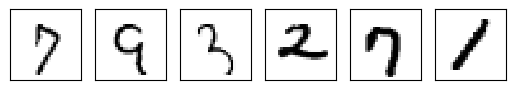

In [40]:
plot_images_separately(data[:6,0].data.cpu().numpy())